# Max-Cut + Ising + Simulated Annealing + 1 parámetro
Este proyecto tiene como objetivo:

> **Explorar cómo la temperatura inicial afecta la calidad de las soluciones al resolver Max-Cut mediante un solver estocástico tipo Ising.**

## Esquema del código
```mermaid
    graph LR
    A[1 <br> Crear un grafo aleatorio usando el modelo Erdős-Rényi] --> B[ 2 <br> Definición del valor del corte y de la energía Ising]
    B --> C[3 <br> Calculo del cambio de energía al voltear un spin]
    C --> D[4 <br> Implementación de Simulated Annealing]
    D --> E[5 <br> Definición del experimento, barrido en T_0 para múltiples corridas]
    
    style A fill: #915a7bff
    style B fill: #915a7bff
    style C fill: #915a7bff
    style D fill: #915a7bff 
    style E fill: #915a7bff
```

In [3]:
import math
import random
from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


1. Crear un grafo aleatorio usando el modelo Erdős-Rényi (G(n,p))
    - `n=n`: Con n nodos
    - `p=p`: Cada posible arista existe con probabilidad p
    - `seed=seed`: Semilla para reproducibilidad
    - `directed=False`: Grafo no dirigido (sin flechas)

In [4]:
def make_random_weighted_graph(
    n: int = 12,
    p: float = 0.3,
    seed: int = 42,
    weight_low: int = 1,
    weight_high: int = 5
) -> nx.Graph:
    rng = random.Random(seed)
    G = nx.gnp_random_graph(n=n, p=p, seed=seed, directed=False)

    for (i, j) in G.edges():
        G[i][j]["w"] = rng.randint(weight_low, weight_high)

    return G

G = make_random_weighted_graph(n=12, p=0.3, seed=1, weight_low=1, weight_high=5)
G.number_of_nodes(), G.number_of_edges()


(12, 21)

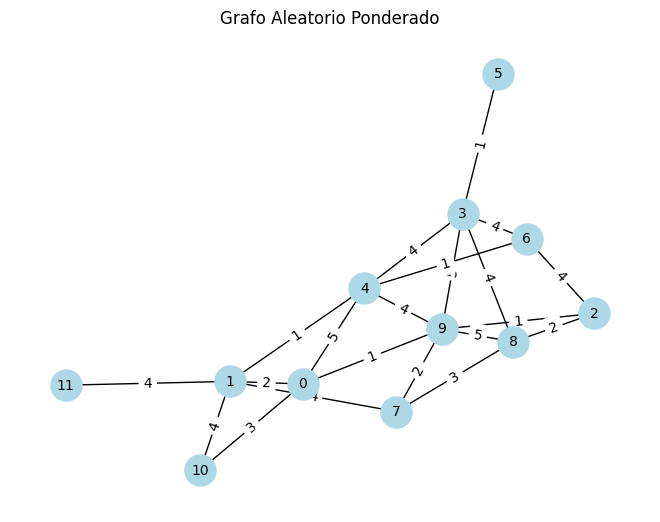

In [5]:
# Dibujar el grafo
pos = nx.spring_layout(G)  # Posiciones de los nodos
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=10)

# Agregar etiquetas de peso a las aristas
edge_labels = nx.get_edge_attributes(G, 'w')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Grafo Aleatorio Ponderado")
plt.show()

2. Definición del valor del corte y de la energía Ising 

    **Función `cut_value`**
    - `G: nx.Graph`: Grafo de entrada
    - `s: np.ndarray`: Arreglo NumPy que representa la partición/spines de nodos
    - `-> float:`: Retorna un float `total`
    - $ cut = \sum_{ij} w_{ij}1 (s_i \neq s_j)$

    **Función `energy_maxcut`**
    - `G: nx.Graph`: Grafo de entrada
    - `s: np.ndarray`: Arreglo NumPy que representa la partición/spines de nodos
    - `-> float:`: Retorna un float `E`
    - $ E(\textbf{s}) = - \sum_{ij} w_{ij} \dfrac{1-s_{ij}}{2}$ 

    De tal manera que:

    `energy_maxcut(G, s)` = `-cut_value(G, s)`

In [6]:

def cut_value(G: nx.Graph, s: np.ndarray) -> float:
    total = 0.0
    for i, j, data in G.edges(data=True):
        w = data["w"]
        if s[i] != s[j]:
            total += w
    return total



def energy_maxcut(G: nx.Graph, s: np.ndarray) -> float:
    E = 0.0
    for i, j, data in G.edges(data=True):
        w = data["w"]
        E += -w * (1 - s[i] * s[j]) / 2.0
    return E

3. Calculo del cambio de energía al voltear un spin 
    - `G: nx.Graph`: Grafo de entrada
    - `s: np.ndarray`: Arreglo NumPy que representa la partición/spines de nodos
    - `i: int`: Índice del nodo que se va a cambiar de grupo 
    - `-> float:`: Retorna un float $\Delta E$
    - $\Delta E_{ij} = -w_{ij}s_is_j$ 

In [7]:
def delta_energy_flip_maxcut(G: nx.Graph, s: np.ndarray, i: int) -> float:
    si = s[i]
    dE = 0.0
    for j in G.neighbors(i):
        w = G[i][j]["w"]
        dE += -w * si * s[j]
    return dE

4. Implementación de Simulated Annealing 
- `@dataclass`: Decorardor que genera en automático métodos especiales 
- `class SAResult`: Define una clase para almacenar resultados del SA
    - `best_energy`: Mejor energía encontrada durante todo el proceso 
    - `best_cut`: Mejor valor de corte correspondiente 
    - `final_energy`: Energía del estado final 
    - `final_cut`:Valor del corte del estado final 
- **Función `simulated_anneling_maxcut`**
    - `G: nx.Graph`: Grafo de entrada
    - `T0`: Temperatura inicial 
    - `Tf: float = 0.1`: Temperatura final 
    - `n_steps: int = 2000`: Número de iteraciones
    - `seed: int = 0`: Semilla para reproducibilidad 
    - `-> SAResult`: Va a retornar un objeto de la clase que se definio previamente SAResult 
    

In [8]:
@dataclass
class SAResult:
    best_energy: float
    best_cut: float
    final_energy: float
    final_cut: float

def simulated_annealing_maxcut(
    G: nx.Graph,
    T0: float,
    Tf: float = 0.1,
    n_steps: int = 2000,
    seed: int = 0
) -> SAResult:
    rng = random.Random(seed)
    n = G.number_of_nodes()

    # Estado inicial aleatorio
    s = np.array([1 if rng.random() < 0.5 else -1 for _ in range(n)], dtype=int)

    E = energy_maxcut(G, s)
    C = cut_value(G, s)

    best_E = E
    best_C = C

    for t in range(n_steps):
        # schedule lineal
        T = T0 + (Tf - T0) * (t / (n_steps - 1))

        # proponer flip
        i = rng.randrange(n)
        dE = delta_energy_flip_maxcut(G, s, i)

        # Metropolis
        if dE <= 0:
            accept = True
        else:
            accept = rng.random() < math.exp(-dE / max(T, 1e-12))

        if accept:
            s[i] *= -1
            E += dE
            C = cut_value(G, s)  # Para N pequeño está ok recalcular hehe

            if E < best_E:
                best_E = E
                best_C = C

    return SAResult(best_energy=best_E, best_cut=best_C, final_energy=E, final_cut=C)


In [9]:
result = simulated_annealing_maxcut(
    G=G,
    T0=15.0,
    Tf=0.1,
    n_steps=5000,
    seed=42
)

print(f"Mejor corte encontrado: {result.best_cut}")
print(f"Corte final: {result.final_cut}")
print(f"Mejor energía: {result.best_energy}")
print(f"Energía final: {result.final_energy}")
print(f"Verificación: -mejor_energy = {-result.best_energy}, best_cut = {result.best_cut}")

Mejor corte encontrado: 52.0
Corte final: 51.0
Mejor energía: -52.0
Energía final: -51.0
Verificación: -mejor_energy = 52.0, best_cut = 52.0


5. Definición del experimento, barrido en $T_0$ para múltiples corridas 
- **Función `run_experiment`**:
    - `G: nx.Graph`: Grafo de entrada
    - `T0_values: List[float]`: Lista de los valores de la temperatura inicial que se van a probar 
    - `runs_per_T0: int = 10`: Número de ejecuciones por temperatura 
    - `Tf:float = 0.1`: Temperatura final fija 
    - `n_steps: int = 2000`: Número de iteraciones
    - `base_seed: int = 7`: Semilla para reproducibilidad 
    - `-> pd.DataFrame` Va a retornar un dataframe de pandas con los resultados del experimento


In [10]:
def run_experiment(
    G: nx.Graph,
    T0_values: List[float],
    runs_per_T0: int = 10,
    Tf: float = 0.1,
    n_steps: int = 2000,
    base_seed: int = 7
) -> pd.DataFrame:
    rows = []
    for idx, T0 in enumerate(T0_values):
        best_Es, best_Cs, final_Es, final_Cs = [], [], [], []

        for r in range(runs_per_T0):
            seed = base_seed + 1000 * idx + r
            res = simulated_annealing_maxcut(G, T0=T0, Tf=Tf, n_steps=n_steps, seed=seed)

            best_Es.append(res.best_energy)
            best_Cs.append(res.best_cut)
            final_Es.append(res.final_energy)
            final_Cs.append(res.final_cut)

        rows.append({
            "T0": T0,
            "runs": runs_per_T0,
            "best_energy_mean": float(np.mean(best_Es)),
            "best_energy_std": float(np.std(best_Es, ddof=1)),
            "best_cut_mean": float(np.mean(best_Cs)),
            "best_cut_std": float(np.std(best_Cs, ddof=1)),
            "final_energy_mean": float(np.mean(final_Es)),
            "final_energy_std": float(np.std(final_Es, ddof=1)),
            "final_cut_mean": float(np.mean(final_Cs)),
            "final_cut_std": float(np.std(final_Cs, ddof=1)),
        })

    return pd.DataFrame(rows).sort_values("T0").reset_index(drop=True)

T0_values = [0.5, 1.0, 2.0, 5.0, 10.0]
df = run_experiment(G, T0_values=T0_values, runs_per_T0=10, Tf=0.1, n_steps=2000, base_seed=7)
df


,T0,runs,best_energy_mean,best_energy_std,best_cut_mean,best_cut_std,final_energy_mean,final_energy_std,final_cut_mean,final_cut_std
0,0.5,10,-50.7,1.702939,50.7,1.702939,-50.7,1.702939,50.7,1.702939
1,1.0,10,-50.9,0.994429,50.9,0.994429,-50.9,0.994429,50.9,0.994429
2,2.0,10,-51.9,0.316228,51.9,0.316228,-50.6,0.843274,50.6,0.843274
3,5.0,10,-52.0,0.000000,52.0,0.000000,-51.1,1.100505,51.1,1.100505
4,10.0,10,-52.0,0.000000,52.0,0.000000,-50.9,1.595131,50.9,1.595131


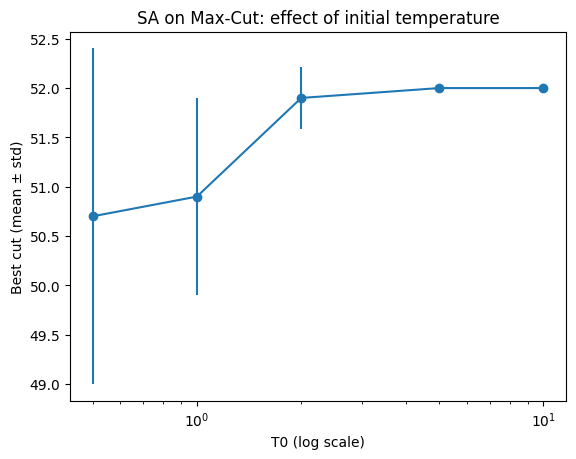

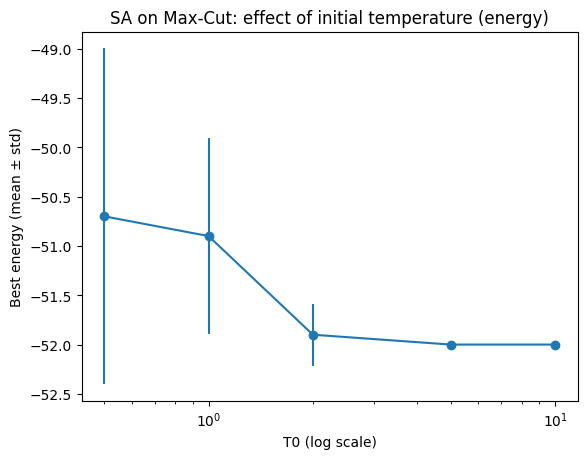

In [11]:
plt.figure()
plt.errorbar(df["T0"], df["best_cut_mean"], yerr=df["best_cut_std"], fmt="o-")
plt.xscale("log")
plt.xlabel("T0 (log scale)")
plt.ylabel("Best cut (mean ± std)")
plt.title("SA on Max-Cut: effect of initial temperature")
plt.show()

plt.figure()
plt.errorbar(df["T0"], df["best_energy_mean"], yerr=df["best_energy_std"], fmt="o-")
plt.xscale("log")
plt.xlabel("T0 (log scale)")
plt.ylabel("Best energy (mean ± std)")
plt.title("SA on Max-Cut: effect of initial temperature (energy)")
plt.show()

**Generación del conjunto de datos para problema de selección de parámetros**

In [12]:
def generate_runs_dataset(
    G,
    T0_values,
    runs_per_T0=20,
    Tf=0.1,
    n_steps=2000,
    base_seed=100
):
    rows = []
    run_id = 0

    for T0 in T0_values:
        for r in range(runs_per_T0):
            seed = base_seed + run_id
            res = simulated_annealing_maxcut(
                G, T0=T0, Tf=Tf, n_steps=n_steps, seed=seed
            )

            rows.append({
                "run_id": run_id,
                "T0": T0,
                "logT0": np.log(T0),
                "seed": seed,
                "best_cut": res.best_cut,
                "final_cut": res.final_cut,
                "best_energy": res.best_energy,
                "final_energy": res.final_energy,
            })
            run_id += 1

    return pd.DataFrame(rows)


In [ ]:
T0_all = [0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 5.0, 7.0, 10.0]

df_runs = generate_runs_dataset(
    G,
    T0_values=T0_all,
    runs_per_T0=20
)

df_runs.shape

(180, 8)

In [15]:
df_runs.head()

,run_id,T0,logT0,seed,best_cut,final_cut,best_energy,final_energy
0,0,0.5,-0.693147,100,52.0,52.0,-52.0,-52.0
1,1,0.5,-0.693147,101,51.0,51.0,-51.0,-51.0
2,2,0.5,-0.693147,102,52.0,52.0,-52.0,-52.0
3,3,0.5,-0.693147,103,52.0,52.0,-52.0,-52.0
4,4,0.5,-0.693147,104,52.0,52.0,-52.0,-52.0


In [16]:
df_runs.to_csv("C:/Users/nat27/Desktop/Desktop/Proyectos/Physics/MaxCut-Ising-Annealing/data/sa_maxcut_runs_dataset.csv", index=False)